## IMPORT MODULES

In [140]:
from pathlib import Path
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import os, pickle, spacy
import matplotlib.pyplot as plt
%matplotlib inline   

import session_info
session_info.show()

## HELPER FUNCTIONS

In [141]:
def load_DataFrame(folder: str, filename: str, print_msg: bool = True):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Load a pandas dataframe from disk that was previously saved
    using the Pickle file format
    ---------------------------------------------------------------------
    
    
    Parameters:
    ---------------------------------------------------------------------
    folder    : the name of the folder to search for file (string)
    filename  : the name of the file to load  (string)
    print_msg : if True, then print the message that the file has been saved
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    df : the pandas dataframe that was previously saved to disk
    
    ---------------------------------------------------------------------
    '''
    df = None
    
    try:
        # Set the filepath
        current_directory = Path(".")
        filepath = os.path.join(current_directory, folder, filename)
        
        with open(filepath, 'rb') as handle:
            df = pickle.load(handle)
        
        if print_msg:
            print(f'Loaded: {filename}')
        
    except:
        print(f'Problem loading :{filename} : \n {filepath}')
        
    return(df)

In [142]:
def show_all_columns(df: pd.DataFrame, rows_to_show: int = 10):
    '''
    Functionality:
    ---------------------------------------------------------------------
    This function will display ALL columns of the dataframe (df), 
    and only the number of rows specified. 
    
    Default number of rows to show = 10
    ---------------------------------------------------------------------
    
    Parameters:
    ---------------------------------------------------------------------
    df           : a pandas dataframe
    rows_to_show : an integer which determines the number of rows to show
    ---------------------------------------------------------------------
    '''
    
    pd.set_option('display.max_columns', None) # change setting to display all columns
    display(df.head(rows_to_show))             # display the dataframe
    pd.reset_option('display.max_columns')     # reset back to normal display setting
    

In [143]:
def is_not_NaN(num):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Checks if the 'num' value is not equal to NaN
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    num : the value to be checked
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    True : if num is not NaN
    False: if num is NaN
    ---------------------------------------------------------------------
    '''
    
    return num == num

In [144]:
def remove_units(df: pd.DataFrame, column_A: str, unit_to_remove: str, add_space: bool = True):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Removes the units (eg. mm) from the values in the specified column
    of the dataframe (df). 
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to use
    column_A       : the column within the dataframe to modify
    unit_to_remove : the unit to remove from each value in the column
    add_space      : whether or not to add a space to the unit in question
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    df: the pandas dataframe that has had the units removed.
    ---------------------------------------------------------------------
    '''
    if add_space:
        unit = ' ' + unit_to_remove
    else:
        unit = unit_to_remove
        
    df[column_A] = df[column_A].str.replace(unit, '') 
    return (df)


In [145]:
def fix_column_name(df: pd.DataFrame, column_A: str, unit_to_insert: str):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Inserts the specified unit into the column name of a dataframe (df) 
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to use
    column_A       : the column within the dataframe to modify
    unit_to_insert : the unit to insert into the column name
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    df: the pandas dataframe with the new column name
    ---------------------------------------------------------------------
    '''
    df = df.rename(columns = {column_A: f'{column_A} ({unit_to_insert})'})
    return (df)


## DIVIDE THE MASTER DATAFRAME - TRAIN / TEST

    
 - **Split into Training and Testing Sets**
     - Training set (80%) : Testing set (20%) split
     - using random_state = 19 - for reproducibility<br>
<br>     
 - **Display the first 2 rows of the Training set**

In [196]:
folder = 'Product'
filename = 'Master_df.pkl'

# Load the master dataframe into memory
master_df = load_DataFrame(folder, filename)

# Extract only those products that have reviews
master_df['Rev_Count'] = [int(review_count.split(" ")[1]) if review_count is not None else 0 for review_count in master_df['Review_Count']] 
products_with_reviews = master_df[master_df['Rev_Count'] > 0] 
        
# TRAIN / TEST SPLIT : get the indices for training and testing (80% train, 20% test)
training_index, testing_index = train_test_split(products_with_reviews.index, train_size=0.8, random_state=19)

#Show the number of products selected for training and testing
print('-----------------------------------------------')
print(f'Training Index Shape: {training_index.shape}')
print(f'Testing Index Shape: {testing_index.shape}')   
print('')

# Create the training set using the training_index (and display the first two rows of the training set)
training_set = master_df.iloc[training_index, :]
training_set.reset_index(drop=True, inplace=True)
show_all_columns(training_set, 2)

Loaded: Master_df.pkl
-----------------------------------------------
Training Index Shape: (103,)
Testing Index Shape: (26,)



,ID,Product_Name,Product_Link,Price,Review_Count,Review_Score,Original_Price,Overview,Brand,Model Number,Finish Colour,Finish Colour Description,Height (mm),Width (mm),Depth (mm),Weight (kg),Accessories included,Manufacturer Warranty,Use,Screen Technology,Screen Size,HD Type,Wide Colour Gamut,Recommended Viewing Distance (cm),Speaker Channels,Total Power,High Dynamic Range (HDR),HDR10+,Upscaling,USB File Playback,Google Assistant,Amazon Alexa Compatible,Bixby,SmartThings,AirPlay2,Operating System,Processor,FreeView+ Compatibility,Netflix Compatibility,Stan Compatibility,Apps,Streaming Services,Android App,Display Mirroring,Bluetooth,Ethernet,WiFi,Composite In,HDMI Ports (IN),HDMI Version,HDMI-eARC,HDMI-CEC,RF Connection In,USB Ports,USB Type,Digital Optical Audio Out,Height with Stand,Width with Stand,Depth with Stand,Weight with Stand,Stand Size (W x D),Package Dimensions (H x W x D),Package Weight (kg),TV Energy Star Rating,Energy Consumption(kWh/annum),Year,1_star,2_star,3_star,4_star,5_star,Review_flat_count,Review_flat_1_star,Review_flat_2_star,Review_flat_3_star,Review_flat_4_star,Review_flat_5_star,Review_flat_avg_star,Review_num,Review_star_count,Review_customer_name,Review_date,Review_title,Review_text,Review_originally_posted,Review_disclaimer_size,Lighting Technology,Local Dimming,VESA Mount,Dolby Vision,Chromecast,Airplay,Voice Control,HDCP Version,Headphone Out,HDMI-ARC,Wall Mount Screw Type Required,Wall Mount Screw Length Required,Warranty Note,Brightness,USB Playback Formats,iOS App,Network File Sharing,Notes,Component In,Features,AUX In,Motion Control,Digital Optical Audio In,Curved,Rev_Count
0,00122,Hisense 55 Inch U7G 4K UHD HDR Smart ULED TV 5...,https://www.appliancesonline.com.au/product/hi...,"$1,301",from 3 reviews,3.0,None,"Culminating in superb contrast, colour, and cl...",Hisense,55U7G,Black,NaN,719 mm,1227 mm,78 mm,14.7 Kg,"Remote Control, Batteries, User Manual",3 Years,Not intended or designed for commercial use.,ULED .,55 Inch,Ultra HD- 4K,tick,165 cm,2 Ch,20 Watts,tick,NaN,tick,tick,Built In,tick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tick,tick,tick,tick,4,2.0,tick,tick,tick,2,2.0,tick,781 mm,1227 mm,241 mm,15 kg,1120 x 241 mm,821 x 1362 x 145 mm,20 kg,4.5 Stars,380,2021,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back Lit,Full Array,300 x 200,tick,NaN,NaN,NaN,2.2,tick,NaN,M6,10 mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,00037,Sony 77 Inch A80J 4K UHD HDR OLED Smart Google...,https://www.appliancesonline.com.au/product/so...,"$8,999",from 528 reviews,4.6,None,With the true blacks of the OLED screen contra...,Sony,XR77A80J,Black,NaN,999 mm,1722 mm,54 mm,28.9 Kg,"Remote Control, Batteries, User Manual",1 Year,Not intended or designed for commercial use.,OLED .,77 Inch,Ultra HD- 4K,tick,230 cm,NaN,NaN,tick,NaN,tick,tick,Built In,tick,NaN,NaN,NaN,Google TV,Cognitive Processor XR,tick,tick,tick,tick,tick,tick,tick,tick,tick,tick,tick,4,2.0,tick,tick,tick,2,2.0,tick,1022 mm,1722 mm,367 mm,30.1 kg,1034 x 367 mm,1141 x 1860 x 190 mm,40 kg,4.5 Stars,693,2021,10.0,15.0,29.0,90.0,384.0,319.0,7.0,14.0,23.0,54.0,221.0,4.47,00000|00001|00002|00003|00004|00005|00006|0000...,5|5|5|5|5|4|5|5|5|4|5|4|5|5|5|5|5|5|5|5|2|5|5|...,Ianmaw|Nucky|Davidp916|Bubs66|Jim Glasgow|Iron...,2021-11-28|2021-11-27|2021-11-27|2021-11-27|20...,Quality | Great picture | Great TV | Fantasti...,Bought direct from a Sony Centre as knowledge...,Originally posted on sony.com.| Originally po...,None|None|None|None|None|None|None|None|None|N...,Self Emitting,Yes,300 x 300,tick,tick,tick,tick,2.3,tick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,528


In [197]:
# Show the list of column names in the training set
training_set_columns = training_set.columns.tolist()
print(training_set_columns)

['ID', 'Product_Name', 'Product_Link', 'Price', 'Review_Count', 'Review_Score', 'Original_Price', 'Overview', 'Brand', 'Model Number', 'Finish Colour', 'Finish Colour Description', 'Height (mm)', 'Width (mm)', 'Depth (mm)', 'Weight (kg)', 'Accessories included', 'Manufacturer Warranty', 'Use', 'Screen Technology', 'Screen Size', 'HD Type', 'Wide Colour Gamut', 'Recommended Viewing Distance (cm)', 'Speaker Channels', 'Total Power', 'High Dynamic Range (HDR)', 'HDR10+', 'Upscaling', 'USB File Playback', 'Google Assistant', 'Amazon Alexa Compatible', 'Bixby', 'SmartThings', 'AirPlay2', 'Operating System', 'Processor', 'FreeView+ Compatibility', 'Netflix Compatibility', 'Stan Compatibility', 'Apps', 'Streaming Services', 'Android App', 'Display Mirroring', 'Bluetooth', 'Ethernet', 'WiFi', 'Composite In', 'HDMI Ports (IN)', 'HDMI Version', 'HDMI-eARC', 'HDMI-CEC', 'RF Connection In', 'USB Ports', 'USB Type', 'Digital Optical Audio Out', 'Height with Stand', 'Width with Stand', 'Depth with S

## DATA CLEANING

Create a function to standardise the process of cleaning-up the dataframe.

In [198]:
def clean_dataframe(df: pd.DataFrame):
    '''
    Functionality:
    -------------------------------------------------------------------------------------------------------------
    This function will clean the dataframe (df) by:
    
     - 1. converting price to a numeric value                 (eg.            '$1,455' ---> 1455  ,              )
     - 2. extract original price from 'Original_price'        (eg. '120off RRP of 779' ---> 779   ,              )
     - 3. convert columns 'with ticks' to binary              (eg.             'tick'  --->   1   ,   NaN ---> 0 )
     - 4. extract the number of reviews from 'Review_Count'   (eg.   'from 20 reviews' --->  20   ,  None ---> 0 )
     - 5. remove units from values                            (eg.            '656 mm' ---> 656   ,              )
     - 6. remove repetitive text from EVERY value in the column
     - 7. combine 'Finish Colour' with 'Finish Colour Description'
     - 8. deal with missing values
     - 9. derive new columns based on specific conditions
     - 10. remove unwanted columns  
     - 11. convert some columns to numeric
     - 12. combine categorical columns   (OPTIONAL??) *********  ******  ******  *********  ******  *********  *******  **********  ************  ************  **********  *********   *******  ********
    -------------------------------------------------------------------------------------------------------------
    
    Parameters:
    -------------------------------------------------------------------------------------------------------------
    df           : a pandas dataframe to be cleaned.
    -------------------------------------------------------------------------------------------------------------
    
    Returns:
    -------------------------------------------------------------------------------------------------------------
    clean_df : a clean dataframe
    -------------------------------------------------------------------------------------------------------------
    '''
    
    # prepare the clean_df and leave the original dataframe untouched
    clean_df = None
    clean_df = df.copy(deep=True)
    
    
    # 1. converting price to a numeric value (eg.'$1,455' ---> 1455)   ------------------------------------------
    clean_df['Price'] = [int(price.replace('$','').replace(',','')) for price in clean_df['Price'] if price is not None]
    
    
    
    # 2. extract original price from 'Original_price' (eg. '$120 off RRP of $779' ---> 779) ---------------------
    clean_df['Original_Price'] = [int(orig_price.replace(',','').split("$")[2]) if orig_price is not None else clean_df.Price.iloc[i] for i, orig_price in enumerate(clean_df['Original_Price'])]
    
    
    
    # 3. convert columns 'with ticks' to binary  (eg.'tick'  --->   1   ,   NaN ---> 0 ) ------------------------
    df_columns = df.columns.tolist()
    tick_columns = df.isin(['tick']).any()
    columns_with_ticks = [feature for feature, has_ticks in zip(df_columns, tick_columns) if has_ticks == True]
    
    for col in columns_with_ticks:
        clean_df.loc[clean_df[col] != 'tick', col] = 0     # does not have a tick
        clean_df.loc[clean_df[col] == 'tick', col] = 1     # has a tick
    
    
    
    
    # 4. extract the number of reviews from 'Review_Count' (eg.'from 20 reviews' --->  20  ,  None ---> 0 ) -----
    clean_df['Review_Count'] = [int(review_count.split(" ")[1]) if review_count is not None else 0 for review_count in clean_df['Review_Count']] 
    
    
    
    
    # 5. remove units from values (eg. '656 mm' ---> 656) -------------------------------------------------------
    # -------------Units removed only
    units_only = {                      'Height (mm)': 'mm',
                                         'Width (mm)': 'mm',
                                         'Depth (mm)': 'mm',
                                        'Weight (kg)': 'Kg',
                              'Manufacturer Warranty': 'Year',
                                        'Screen Size': 'Inch',
                  'Recommended Viewing Distance (cm)': 'cm',
                                         'Brightness': 'Nits',
                              'TV Energy Star Rating': 'Stars',
                                        'Total Power': 'Watts'}

    for key, value in units_only.items():  
        clean_df = remove_units(clean_df, key, value)
    
    # ----------------------Remove residual 's' in this column
    remove_units(clean_df, 'Manufacturer Warranty', 's', False)

    # --------------------Insert units into column names
    units_into_column = {'Manufacturer Warranty': 'Years',
                                   'Screen Size': 'Inches',
                                   'Total Power': 'Watts'}
                    
    for key, value in units_into_column.items():  
        clean_df = fix_column_name(clean_df, key, value)
    
    
    
    
    # 6. remove repetitive text from EVERY value in the column
    clean_df['Review_originally_posted'] = clean_df['Review_originally_posted'].str.replace('Originally posted on ', '', regex=False)
    clean_df['Review_text'] = clean_df['Review_text'].str.replace('[This review was collected as part of a promotion.]', '', regex=False)
    
    
    
    
    # 7. combine 'Finish Colour' with 'Finish Colour Description'  ----------------------------------------------
    new_values = []
    for i, cell in enumerate(clean_df['Finish Colour Description']):
        if isinstance(cell, float):
            new_values.append(clean_df['Finish Colour'][i])
        else:
            new_values.append(cell)

    clean_df['Finish Colour Description'] = new_values   # 'Finish colour' will be deleted in step 10
    
    
    
    
    # 8. deal with missing values -------------------------------------------------------------------------------
    not_mentioned = ['Overview', 'Operating System', 'Processor', 'HDMI Version', 'USB Type', 'Lighting Technology', 
                     'Local Dimming', 'HDCP Version', 'Brightness', 'Accessories included', 'Speaker Channels',
                     'Google Assistant', 'USB Playback Formats']
    
    # Replace some columns with missing values with 'not mentioned'
    clean_df[not_mentioned] = clean_df[not_mentioned].fillna(value='not mentioned')
    clean_df['Review_originally_posted'] = clean_df['Review_originally_posted'].fillna(value='appliances online')
    
    # Will keep some information rather than remove the column (many missing)
    power_watts = []
    for cell in clean_df['Total Power (Watts)'].apply(pd.to_numeric):
        if cell <= 25:
            power_watts.append('low')
        elif cell > 25 and cell <=75:
            power_watts.append('medium')
        elif cell > 75:
            power_watts.append('high')
        else:
            power_watts.append('not mentioned')
    
    clean_df['Power'] = power_watts
    
    # Will keep some information rather than remove the column (many missing)
    view_distance = []
    for cell in clean_df['Recommended Viewing Distance (cm)'].apply(pd.to_numeric):
        if cell <= 160:
            view_distance.append('close')
        elif cell > 160 and cell <=220:
            view_distance.append('normal')
        elif cell > 220:
            view_distance.append('far')
        else:
            view_distance.append('not mentioned')
    
    clean_df['Viewing Distance'] = view_distance
    
    
    # Show histogram of Total Power (Watts) and Recommended Viewing Distance (cm) before and after transformation
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    fig.tight_layout(pad=3)

    bins = np.linspace(0, 100, 20)
    ax1.hist(clean_df['Total Power (Watts)'].apply(pd.to_numeric),bins, alpha = 0.6, color = 'r')
    ax1.set(title="Total Power", xlabel='Watts', ylabel='Frequency')

    clean_df['Power'].value_counts().plot(kind='bar', alpha = 0.4, color = 'r', ax = ax2)
    ax2.set(title="Total Power (after)", ylabel='Frequency')

    bins = np.linspace(100, 400, 20)
    ax3.hist(clean_df['Recommended Viewing Distance (cm)'].apply(pd.to_numeric), alpha = 0.6, color = 'b')
    ax3.set(title="Viewing Distance", xlabel='cm', ylabel='Frequency')

    clean_df['Viewing Distance'].value_counts().plot(kind='bar', alpha = 0.4, color = 'b', ax = ax4)
    ax4.set(title="Viewing Distance (after)", ylabel='Frequency')
    plt.show()   
    
    # Fill the remaining missing values with zero
    clean_df.fillna(value=0, inplace=True) 
    
    
    
    
    # 9. derive new columns based on specific conditions --------------------------------------------------------
    clean_df['Discount'] = [(int(orig) - int(new_price)) for orig, new_price in zip(clean_df['Original_Price'], clean_df['Price'])]
        
    
    
    
    # 10. remove unwanted columns --------------------------------------------------------------------------------
    unwanted_columns = ['Use' , 'Height with Stand', 'Width with Stand', 'Depth with Stand', 'Weight with Stand', 
                        'Stand Size (W x D)','Package Weight (kg)', 'Package Dimensions (H x W x D)', 
                        'Wall Mount Screw Type Required', 'VESA Mount', 'Features', 'Wall Mount Screw Length Required', 
                        'Warranty Note', 'Notes', 'Review_disclaimer_size', 'Finish Colour',
                        'Energy Consumption(kWh/annum)', 'Total Power (Watts)', 'Rev_Count', 
                        'Recommended Viewing Distance (cm)']
                             
    clean_df = clean_df.drop(unwanted_columns, axis = 1)
    
    
    
    
    
    # 11. Convert some columns to numeric------------------------------------------------------------------------
    convert_to_numeric = ['Height (mm)', 'Width (mm)', 'Depth (mm)', 'Weight (kg)', 'Manufacturer Warranty (Years)', 
                          'Screen Size (Inches)', 'USB Ports', 'HDMI Ports (IN)'] 
    clean_df[convert_to_numeric] = clean_df[convert_to_numeric].apply(pd.to_numeric)
    
    
    
    
    # 12. combine categorical columns ---------------------------------------------------------------------------
    
    
    
    return(clean_df)

    


## Clean the training dataset

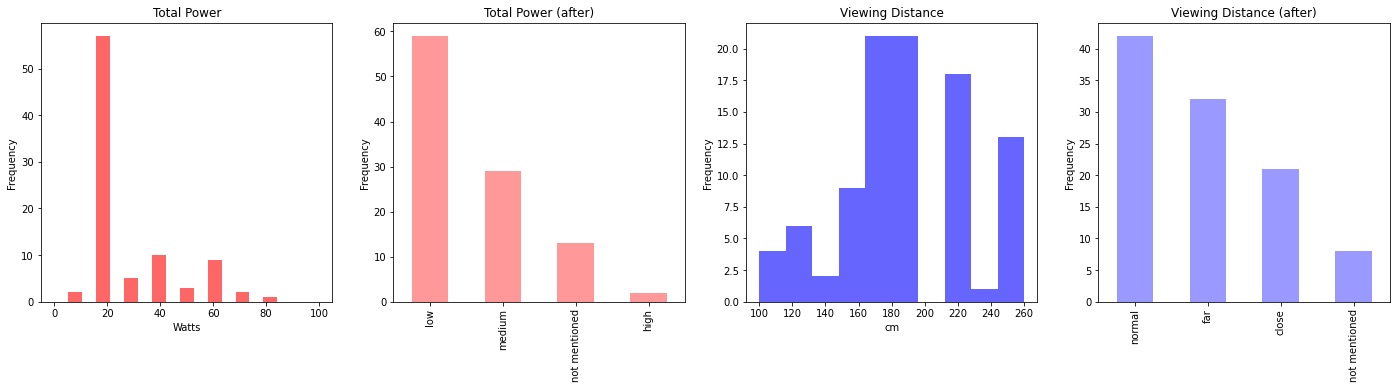

,ID,Product_Name,Product_Link,Price,Review_Count,Review_Score,Original_Price,Overview,Brand,Model Number,...,iOS App,Network File Sharing,Component In,AUX In,Motion Control,Digital Optical Audio In,Curved,Power,Viewing Distance,Discount
0,00122,Hisense 55 Inch U7G 4K UHD HDR Smart ULED TV 5...,https://www.appliancesonline.com.au/product/hi...,1301,3,3.0,1301,"Culminating in superb contrast, colour, and cl...",Hisense,55U7G,...,0,0,0,0,0,0,0,low,normal,0
1,00037,Sony 77 Inch A80J 4K UHD HDR OLED Smart Google...,https://www.appliancesonline.com.au/product/so...,8999,528,4.6,8999,With the true blacks of the OLED screen contra...,Sony,XR77A80J,...,0,0,0,0,0,0,0,not mentioned,far,0


In [199]:
training_set = clean_dataframe(training_set)
training_set.head(2)

## EXPLORATORY DATA ANALYSIS

### Training set columns

In [200]:
training_set_columns = training_set.columns.tolist()
print(training_set_columns)

['ID', 'Product_Name', 'Product_Link', 'Price', 'Review_Count', 'Review_Score', 'Original_Price', 'Overview', 'Brand', 'Model Number', 'Finish Colour Description', 'Height (mm)', 'Width (mm)', 'Depth (mm)', 'Weight (kg)', 'Accessories included', 'Manufacturer Warranty (Years)', 'Screen Technology', 'Screen Size (Inches)', 'HD Type', 'Wide Colour Gamut', 'Speaker Channels', 'High Dynamic Range (HDR)', 'HDR10+', 'Upscaling', 'USB File Playback', 'Google Assistant', 'Amazon Alexa Compatible', 'Bixby', 'SmartThings', 'AirPlay2', 'Operating System', 'Processor', 'FreeView+ Compatibility', 'Netflix Compatibility', 'Stan Compatibility', 'Apps', 'Streaming Services', 'Android App', 'Display Mirroring', 'Bluetooth', 'Ethernet', 'WiFi', 'Composite In', 'HDMI Ports (IN)', 'HDMI Version', 'HDMI-eARC', 'HDMI-CEC', 'RF Connection In', 'USB Ports', 'USB Type', 'Digital Optical Audio Out', 'TV Energy Star Rating', 'Year', '1_star', '2_star', '3_star', '4_star', '5_star', 'Review_flat_count', 'Review_f

### Missing values

Shape of the TRAINING SET: (103, 94)


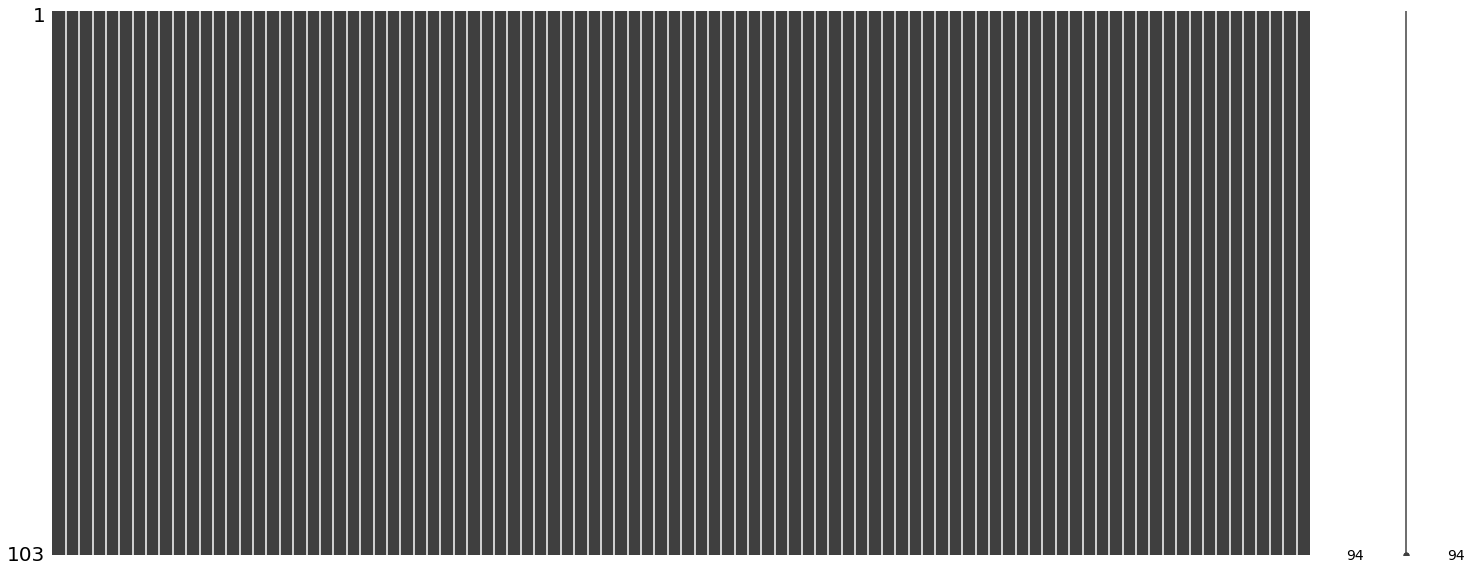

In [201]:
print(f'Shape of the TRAINING SET: {training_set.shape}')

msno.matrix(training_set)
plt.show()

## Descriptive statistics for the numeric variables

In [202]:
show_all_columns(training_set.describe(include=[np.number]).round(2))

,Price,Review_Count,Original_Price,Height (mm),Width (mm),Depth (mm),Weight (kg),Manufacturer Warranty (Years),Screen Size (Inches),Wide Colour Gamut,High Dynamic Range (HDR),HDR10+,Upscaling,USB File Playback,Amazon Alexa Compatible,Bixby,SmartThings,AirPlay2,FreeView+ Compatibility,Netflix Compatibility,Stan Compatibility,Apps,Streaming Services,Android App,Display Mirroring,Bluetooth,Ethernet,WiFi,Composite In,HDMI Ports (IN),HDMI-eARC,HDMI-CEC,RF Connection In,USB Ports,Digital Optical Audio Out,1_star,2_star,3_star,4_star,5_star,Review_flat_count,Review_flat_1_star,Review_flat_2_star,Review_flat_3_star,Review_flat_4_star,Review_flat_5_star,Review_flat_avg_star,Dolby Vision,Chromecast,Airplay,Voice Control,Headphone Out,HDMI-ARC,iOS App,Network File Sharing,Component In,AUX In,Motion Control,Digital Optical Audio In,Curved,Discount
count,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.0,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,103.0,103.0,103.00,103.00,103.00
mean,2948.77,262.24,3140.43,823.40,1422.49,65.18,24.22,1.76,63.63,0.51,0.85,0.33,0.76,0.89,0.70,0.19,0.19,0.19,0.69,0.77,0.72,0.71,0.72,0.49,0.5,0.75,0.95,0.98,0.76,3.51,0.70,0.83,0.91,2.12,0.93,3.43,3.11,8.50,39.90,207.31,67.30,0.83,0.76,2.04,9.96,53.71,2.98,0.55,0.48,0.35,0.55,0.70,0.17,0.07,0.07,0.05,0.0,0.0,0.01,0.01,191.66
std,2726.89,456.19,2786.52,186.50,326.14,43.55,15.25,0.97,14.68,0.50,0.35,0.47,0.43,0.31,0.46,0.40,0.40,0.40,0.47,0.42,0.45,0.46,0.45,0.50,0.5,0.44,0.22,0.14,0.43,0.70,0.46,0.37,0.28,0.55,0.25,4.11,4.42,14.53,68.24,368.74,125.04,1.32,1.72,3.86,18.05,102.12,2.17,0.50,0.50,0.48,0.50,0.46,0.37,0.25,0.25,0.22,0.0,0.0,0.10,0.10,280.34
min,299.00,1.00,299.00,424.00,720.60,17.20,0.00,1.00,32.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
25%,1046.00,4.50,1199.00,709.60,1227.80,46.50,13.20,1.00,55.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.50,1.00,1.00,1.00,3.00,0.00,1.00,1.00,2.00,1.00,0.00,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
50%,2033.00,21.00,2209.00,834.00,1448.00,66.00,20.00,1.00,65.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.0,1.00,1.00,1.00,1.00,4.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,2.00,5.00,11.00,6.00,0.00,0.00,0.00,1.00,5.00,4.30,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,80.00
75%,3854.50,278.00,3999.00,961.15,1675.00,78.00,32.10,3.00,75.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,4.00,1.00,1.00,1.00,2.00,1.00,6.00,4.00,6.00,44.00,205.00,61.00,1.00,1.00,2.00,11.50,48.50,4.73,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,289.50
max,15839.00,1694.00,15999.00,1294.60,2256.80,441.00,94.00,3.00,100.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,4.00,1.00,1.00,1.00,4.00,1.00,12.00,15.00,59.00,264.00,1360.00,569.00,7.00,14.00,23.00,71.00,477.00,5.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,0.0,1.00,1.00,1490.00


## Descriptive statistics for the categorical variables

In [203]:
show_all_columns(training_set.describe(exclude=[np.number]).round(2))

,ID,Product_Name,Product_Link,Review_Score,Overview,Brand,Model Number,Finish Colour Description,Accessories included,Screen Technology,HD Type,Speaker Channels,Google Assistant,Operating System,Processor,HDMI Version,USB Type,TV Energy Star Rating,Year,Review_num,Review_star_count,Review_customer_name,Review_date,Review_title,Review_text,Review_originally_posted,Lighting Technology,Local Dimming,HDCP Version,Brightness,USB Playback Formats,Power,Viewing Distance
count,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103
unique,103,103,103,14,88,9,103,13,15,7,5,8,3,7,11,4,7,11,6,63,66,69,69,69,69,64,6,3,5,12,8,4,4
top,00122,Hisense 55 Inch U7G 4K UHD HDR Smart ULED TV 5...,https://www.appliancesonline.com.au/product/hi...,4.7,not mentioned,Samsung,55U7G,Black,"Remote Control, Batteries, User Manual",LED .,Ultra HD- 4K,2 Ch,Built In,not mentioned,not mentioned,2.0,2.0,4.0,2021,0,0,0,0,0,0,appliances online,not mentioned,not mentioned,not mentioned,not mentioned,not mentioned,low,normal
freq,1,1,1,23,13,24,1,70,46,58,92,56,58,33,47,55,57,26,85,35,35,35,35,35,35,35,52,64,38,82,92,59,42
